In [70]:
import matplotlib.pyplot as plt, mpld3
import re
from dateutil.parser import parse
from matplotlib.patches import ConnectionPatch
import numpy as np
import pandas as pd
import seaborn as sns

In [43]:
with open("C:/Users/Michael/Documents/Jobs/applied_8_9_2022.txt", "r", encoding="utf-8") as file:
    text = file.readlines()

In [48]:
# filter job lines
date_dict = {}

for line in text:
    try: 
        date = parse(line)
        date_dict[date] = []
    except:
        if ":" in line:
            date_dict[date].append(line)

jobs_by_date = [item for sublist in [list(map(lambda vv: (k, vv), v)) for k, v in date_dict.items()] for item in sublist]

In [49]:
df = pd.DataFrame(jobs_by_date, columns=["Date_Applied", "Line"])

In [50]:
df["Company"] = df["Line"].str.strip().str.split(":|-|==>").apply(lambda l: l[0].strip())
df["Title"] = df["Line"].str.strip().str.split(":|-|==>").apply(lambda l: l[1].strip().title())
df["Result"] = df["Line"].str.strip().str.split("==>").apply(lambda l: l[1].strip().title() if len(l) > 1 else "No Response")

In [51]:
# rejection PB is 37 minutes
df["Result"].value_counts(dropna=False)

No Response        118
Rejected            51
Contacted            3
First Interview      3
Scam                 2
Third Interview      1
Name: Result, dtype: int64

In [52]:
df

,Date_Applied,Line,Company,Title,Result
0,2022-08-09,NYT: Data Insights (Games)- wordleBitch123$\n,NYT,Data Insights (Games),No Response
1,2022-08-09,"SPOTIFY: Data Scientist, Spotify for Artists =...",SPOTIFY,"Data Scientist, Spotify For Artists",Rejected
2,2022-08-09,DOW JONES: Data Analyst - wordleBitch123$\n,DOW JONES,Data Analyst,No Response
3,2022-08-09,MANTECH: Data Science/Analytics New Graduate -...,MANTECH,Data Science/Analytics New Graduate,No Response
4,2022-08-09,OSCAR HEALTH: Data Scientist\n,OSCAR HEALTH,Data Scientist,No Response
...,...,...,...,...,...
173,2022-10-31,CLEARLINK: DPR Data Analyst - wordleBitch123$ ...,CLEARLINK,Dpr Data Analyst,Rejected
174,2022-11-01,SOFTNICE: Data Analyst\n,SOFTNICE,Data Analyst,No Response
175,2022-11-01,SOUTHERN CROSS CORPORATION: Data Analyst\n,SOUTHERN CROSS CORPORATION,Data Analyst,No Response
176,2022-11-01,BET+: Data Analyst\n,BET+,Data Analyst,No Response


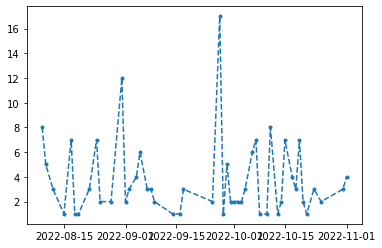

In [53]:
plt.plot(df.groupby("Date_Applied").count()["Line"], "--", marker=".")
#mpld3.show()

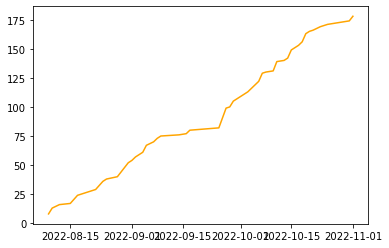

In [28]:
plt.plot(df.groupby("Date_Applied").count()["Line"].cumsum(), c="orange")

Text(0.5, 1.0, 'Results of Responses')

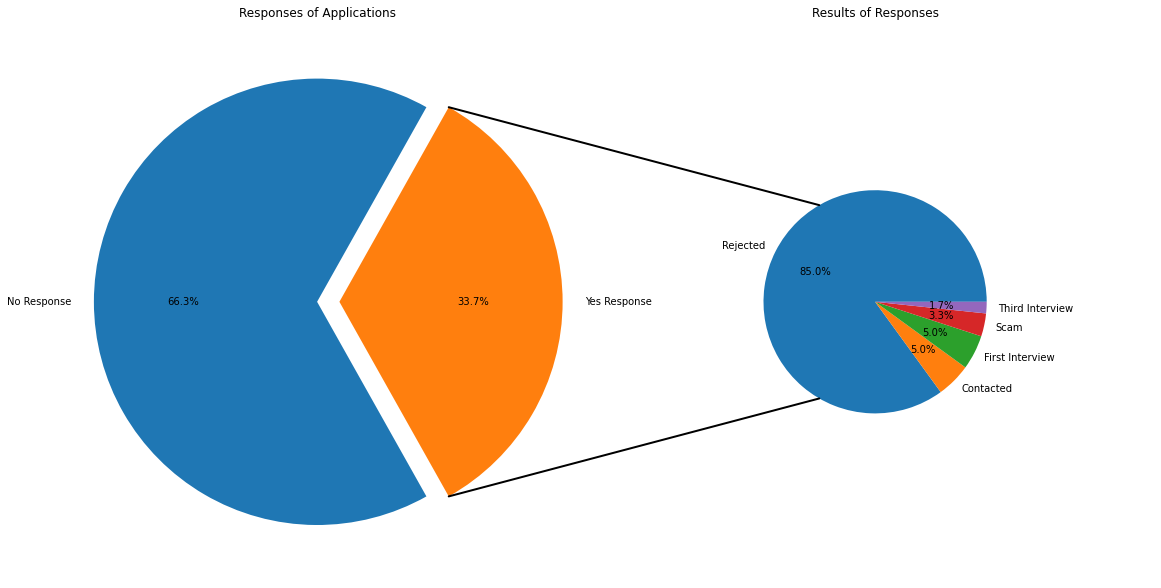

In [113]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,15))
fig.subplots_adjust(wspace=0)

woi = "Yes Response"
explosion_size = 0.1

color_map = {"Rejected": "Red",
            "Scam": "Orange",
            "Contacted": "Yellow"}

response_binary = df["Result"].where(df["Result"] == "No Response", "Yes Response")

pie_data = response_binary
subpie_data = df["Result"][df["Result"] != "No Response"]

## setting up pie chart

# ratios
ratios = pie_data.value_counts() / len(pie_data)

# labels
labels = pie_data.value_counts().index

# get explosions and angle for wedge of interest
explode = [explosion_size if label == woi else 0.0 for label in labels]
angle = 180 * ratios[woi]

# plot pie
wedges, *_ = ax1.pie(pie_data.value_counts(), autopct="%1.1f%%", labels=pie_data.value_counts().index, explode=explode, startangle=angle)

## setting up sub-pie chart

# ratios
ratios = subpie_data.value_counts() / len(subpie_data)

# labels and sizes
labels = subpie_data.value_counts().index

# plot subpie
subwedges, *_ = ax2.pie(subpie_data.value_counts(), autopct="%1.1f%%", labels=subpie_data.value_counts().index, radius=0.5)

## connecting
# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[1].theta1, wedges[1].theta2
center, r = wedges[1].center, wedges[1].r

subcenter, subr = subwedges[0].center, subwedges[0].r

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-subr*np.cos(np.pi / 180 * 60), subr*np.sin(np.pi / 180 * 60)), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)

con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-subr*np.cos(np.pi / 180 * 60), -subr*np.sin(np.pi / 180 * 60)), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)

con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

ax1.set_title("Responses of Applications")
ax2.set_title("Results of Responses")

In [72]:
wedges

In [185]:
response_counts = df["Result"][df["Result"] != "NO RESPONSE"].value_counts().values
response_labels = df["Result"][df["Result"] != "NO RESPONSE"].unique()